In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from transformers import BertTokenizerFast
from datasets import load_dataset
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc
import evaluate
from scipy.special import softmax


# Загрузка данных
dataset = load_dataset("rotten_tomatoes")
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

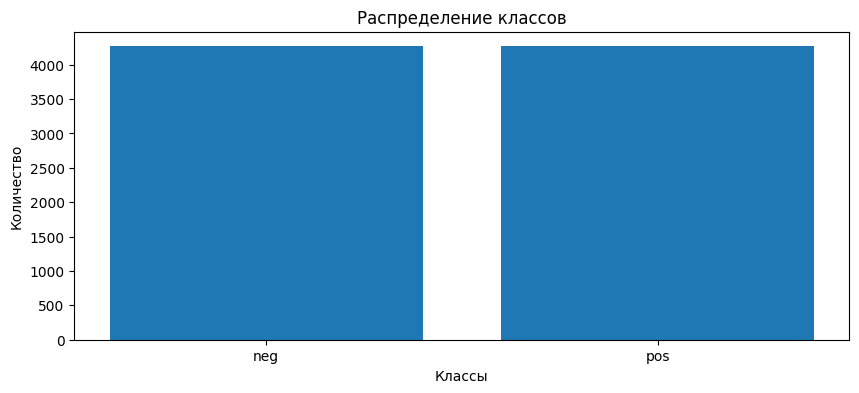

In [3]:
dataset['train'].features['label'].names
label_counts = dataset['train'].features['label'].names
plt.figure(figsize=(10, 4))
plt.bar(label_counts, dataset['train'].to_pandas().label.value_counts())
plt.title('Распределение классов')
plt.ylabel('Количество')
plt.xlabel('Классы')
plt.show()

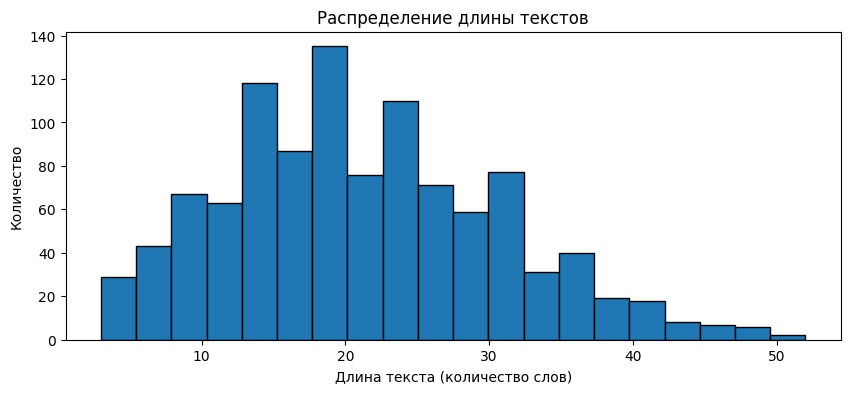

In [4]:
lengths = dataset['test'].to_pandas().text.apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 4))
plt.hist(lengths, bins=20, edgecolor='k')
plt.title('Распределение длины текстов')
plt.ylabel('Количество')
plt.xlabel('Длина текста (количество слов)')
plt.show()

In [9]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding='max_length', max_length=50)

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

train_dataset = tokenized_datasets["train"]
test_dataset = tokenized_datasets["test"]

# MixUp функции
def mixup_data(x, y, alpha=1.0):
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [10]:
# Кастомный Trainer с MixUp
class MixupTrainer(Trainer):
    def training_step(self, model, inputs):
        model.train()
        inputs = self._prepare_inputs(inputs)

        input_ids = inputs['input_ids'].to(self.args.device)
        attention_mask = inputs['attention_mask'].to(self.args.device)
        labels = inputs['labels'].to(self.args.device)

        model_embeddings = model.bert.embeddings(input_ids).detach()
        mixed_embeddings, labels_a, labels_b, lam = mixup_data(model_embeddings, labels)

        outputs = model(inputs_embeds=mixed_embeddings, attention_mask=attention_mask)
        loss = mixup_criterion(F.cross_entropy, outputs.logits, labels_a, labels_b, lam)

        loss.backward()
        return loss.detach()

In [12]:
# Создание модели и запуск тренировки
model = BertForSequenceClassification.from_pretrained("bert-base-cased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=8,
    weight_decay=0.01,
)

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='binary')
    accuracy = metric.compute(predictions=predictions, references=labels)["accuracy"]

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

trainer = MixupTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.581100,0.447035,0.797373,0.782531,0.823640,0.802559
2,0.525700,0.426708,0.826454,0.843874,0.801126,0.821944
3,0.484400,0.384497,0.842402,0.850288,0.831144,0.840607
4,0.453600,0.405269,0.837711,0.839623,0.834897,0.837253
5,0.429100,0.398019,0.831144,0.846758,0.808630,0.827255
6,0.396600,0.489482,0.829268,0.824399,0.836773,0.830540
7,0.372400,0.467823,0.834897,0.829945,0.842402,0.836127
8,0.367400,0.440806,0.831144,0.837476,0.821764,0.829545


TrainOutput(global_step=8536, training_loss=0.45242918397962434, metrics={'train_runtime': 1109.2572, 'train_samples_per_second': 61.519, 'train_steps_per_second': 7.695, 'total_flos': 1753388517360000.0, 'train_loss': 0.45242918397962434, 'epoch': 8.0})

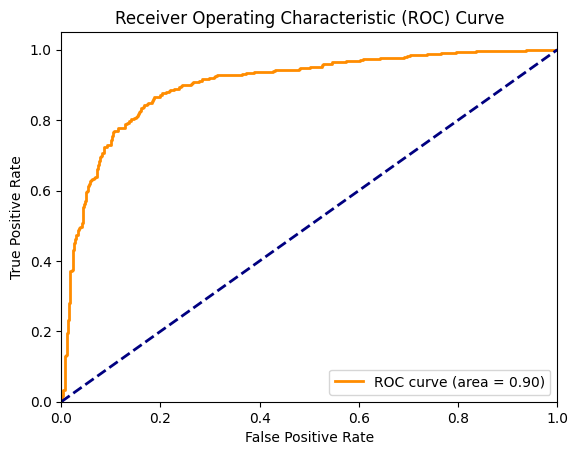

In [13]:
# Получение логитов на тестовом наборе
predictions = trainer.predict(test_dataset)
logits = predictions.predictions
labels = predictions.label_ids

probs = softmax(logits, axis=1)
class_probs = probs[:, 1]

# Построение ROC кривой
fpr, tpr, thresholds = roc_curve(labels, class_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()